This notebook is the Momentum trading strategy for Sebastian Usai's capstone project with WQU.

The first half of this notebook presents a simple mometnum trading strategy.

The second half works off the output files from the first part of the notebook. These files were edited by hand based on the machine learning directional filter. Any trades taken in the opposite direction of the ML filter were removed from the files.

In [137]:
### LIBRARIES   ###

import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import pandas_datareader.data as web
import matplotlib.dates as mdates
style.use ('ggplot')
import numpy as np
from scipy.stats import skew
from scipy.stats import kurtosis
import seaborn as sns

In [138]:
df = pd.read_csv('EURUSD5.csv', parse_dates = True, index_col=0)
df=df.rename(columns = {'1.12349':'Open'})
df=df.rename(columns = {'1.12374':'High'})
df=df.rename(columns = {'1.12349.1':'Low'})
df=df.rename(columns = {'1.12372':'Close'})
df=df.rename(columns = {'161':'Volume'})
df = df.iloc[40070:-12914]

In [139]:
#Long only momentum

window = 100
upper_std = 3 
lower_std = 3
#Calculate rolling mean and standard deviation using number of days set above
rolling_mean = df['Close'].rolling(window).mean()
rolling_std = df['Close'].rolling(window).std()
#create two new DataFrame columns to hold values of upper and lower Bollinger bands and 200ma for trend
df['Rolling Mean'] = rolling_mean
df['Bollinger High'] = rolling_mean + (rolling_std * upper_std)
df['Bollinger Low'] = rolling_mean - (rolling_std * lower_std)
df['MA']=df['Close'].rolling(window=200).mean()
df['Market Return'] = np.log(df['Close'] / df['Close'].shift(1))

#Average daily return over past 110 days for momentum filter
df['R']= (df['Market Return'].rolling(window=100).mean())*100#(our simple momentum indicator)
#Volume Confirmation filters
df['Volume Mean'] = df['Volume'].rolling(window = 100).mean()
df['Volume+'] = df['Volume Mean']*1.5
#Create an "empty" column as placeholder for our /position signals
df['Position'] = None
#Fill our newly created position column - we will buy (1) for an upper band break and go to 0 on a lower band break
        
for row in range(len(df)):
   
    if (df['Close'].iloc[row] > df['Bollinger High'].iloc[row]) and (df['Volume'].iloc[row]>df['Volume+'].iloc[row]) and (df['Close'].iloc[row-1] < df['Bollinger High'].iloc[row-1]) and(df['R'].iloc[row]>0.002):
        df['Position'].iloc[row] = 1    
        
    if (df['Close'].iloc[row] < df['Bollinger Low'].iloc[row]) :
        df['Position'].iloc[row] = 0
        

#Forward fill our position column to replace the "None" values with the correct long/short positions to represent the "holding" of our position
#forward through time
df['Position'].fillna(method='ffill',inplace=True)
#Calculate the daily market return and multiply that by the position to determine strategy returns




#KPI Metrics for long only

df['Strategy Return'] = df['Market Return'] * df['Position'].shift(1)
df['Index Return'] = (1 + df['Strategy Return']).cumprod()
lookback = 1000

# Calculate the max drawdown in the past window days for each day 
df['rolling_max'] = df['Index Return'].rolling(lookback, min_periods=1).max()
df['daily_drawdown'] = df['Index Return']/df['rolling_max'] - 1.0

# Calculate the minimum (negative) daily drawdown
df['max_daily_drawdown'] = df['daily_drawdown'].rolling(lookback, min_periods=1).min()

Regime = df['Position'].rolling(2).apply(lambda x: x[0] != x[-1], raw=True).sum().astype(int)
Buy_Orders = Regime/2

Average_Hold = (df['Position'].sum())/Buy_Orders

Number_of_Hours = len(df.index)

Number_of_Days = Number_of_Hours/24

Time_in_Market1 = (Average_Hold*Buy_Orders)/Number_of_Hours

CAGR = ((df['Strategy Return'].sum())/Number_of_Days)*252

ADJCAGR = CAGR/Time_in_Market1
#Save trimmed dataframe
export_csv = df.to_csv (r'C:\Users\Seb Usai\Anaconda3\AAA WQU CF\Capstone\MomentumLONG.csv', index = True, header=True)

C:\Users\Seb Usai\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [140]:
df2 = pd.read_csv('EURUSD5.csv', parse_dates = True, index_col=0)
df2=df2.rename(columns = {'1.12349':'Open'})
df2=df2.rename(columns = {'1.12374':'High'})
df2=df2.rename(columns = {'1.12349.1':'Low'})
df2=df2.rename(columns = {'1.12372':'Close'})
df2=df2.rename(columns = {'161':'Volume'})

df2 = df2.iloc[40070:-12914]

In [141]:
#Short only momentum

window = 100
upper_std = 3 #<  edit window(number of days in lookback period) and standard deviations here
lower_std = 3
#Calculate rolling mean and standard deviation using number of days set above
rolling_mean = df2['Close'].rolling(window).mean()
rolling_std = df2['Close'].rolling(window).std()
#create two new DataFrame columns to hold values of upper and lower Bollinger bands and 200ma for trend
df2['Rolling Mean'] = rolling_mean
df2['Bollinger High'] = rolling_mean + (rolling_std * upper_std)
df2['Bollinger Low'] = rolling_mean - (rolling_std * lower_std)
df2['MA']=df2['Close'].rolling(window=200).mean()
df2['Market Return'] = np.log(df2['Close'] / df2['Close'].shift(1))

df2['R']= (df2['Market Return'].rolling(window=100).mean())*100
#Volume Confirmation filters
df2['Volume Mean'] = df2['Volume'].rolling(window = 100).mean()
df2['Volume+'] = df2['Volume Mean']*1.5
#Create an "empty" column as placeholder for our /position signals
df2['Position'] = None
#Fill our newly created position column - we will buy (1) for an upper band break and go to 0 on a lower band break
        
for row in range(len(df2)):
   
    if (df2['Close'].iloc[row] < df2['Bollinger Low'].iloc[row]) and (df2['Volume'].iloc[row]>df2['Volume+'].iloc[row]) and (df2['Close'].iloc[row-1] > df2['Bollinger Low'].iloc[row-1])and (df2['R'].iloc[row]<-0.002):
        df2['Position'].iloc[row] = -1    
        
    if (df2['Close'].iloc[row] > df2['Bollinger High'].iloc[row]) :
        df2['Position'].iloc[row] = 0
        

#Forward fill our position column to replace the "None" values with the correct long/short positions to represent the "holding" of our position
#forward through time
df2['Position'].fillna(method='ffill',inplace=True)


#Short only KPI's


#Calculate the daily market return and multiply that by the position to determine strategy returns

df2['Strategy Return'] = df2['Market Return'] * df2['Position'].shift(1)


#Calculate the dollar returns based on the log%'s so we can calc max DD and CAGR

df2['Index Return'] = (1 + df2['Strategy Return']).cumprod()

# Define a trailing 252 trading day window
lookback = 1000

# Calculate the max drawdown in the past window days for each day 
df2['rolling_max'] = df2['Index Return'].rolling(lookback, min_periods=1).max()
df2['daily_drawdown'] = df2['Index Return']/df2['rolling_max'] - 1.0

# Calculate the minimum (negative) daily drawdown
df2['max_daily_drawdown'] = df2['daily_drawdown'].rolling(lookback, min_periods=1).min()

Regime = df2['Position'].rolling(2).apply(lambda x: x[0] != x[-1], raw=True).sum().astype(int)
Buy_Orders = Regime/2

Average_Hold = ((df2['Position'].sum())/Buy_Orders)*-1

Number_of_Hours = len(df2.index)

Number_of_Days = Number_of_Hours/24

Time_in_Market2 = (Average_Hold*Buy_Orders)/Number_of_Hours

CAGR = ((df2['Strategy Return'].sum())/Number_of_Days)*252

ADJCAGR = CAGR/Time_in_Market2

Return = df['Strategy Return'].sum()

#Save trimmed dataframe
export_csv = df2.to_csv (r'C:\Users\Seb Usai\Anaconda3\AAA WQU CF\Capstone\MomentumSHORT.csv', index = True, header=True)

In [142]:
#Now combine

#Now combine to get results
combined_return = (df['Strategy Return'] + df2['Strategy Return'])-((0.0001*11)/len(df))#trading costs(average cost by number of trades by number 0f periods)
df['Combined Return'] = combined_return
df['Combined Cumulative'] = (1 + df['Combined Return']).cumprod()

Total Return = 0.006934223005922683
PORTFOLIO CAGR= 0.0416053380355361
Max Portfolio DD =  -0.011540865014385115
TIME IN MARKET ADJUSTED CAGR= 0.10045983450501733
Percent of time in market= 0.41414898044111526


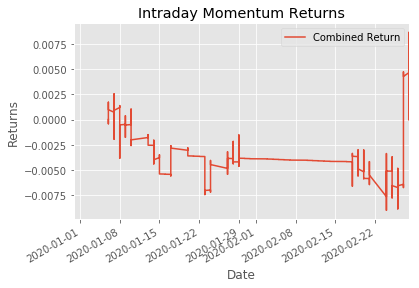

In [143]:
Return = df['Combined Return'].sum()
CAGR = Return*6
lookback = 10000
df['rolling_maximum_combined'] = df['Combined Cumulative'].rolling(lookback, min_periods=1).max()
df['daily_drawdowns'] = df['Combined Cumulative']/df['rolling_maximum_combined'] - 1.0
df['max_daily_drawdown'] = df['daily_drawdowns'].rolling(lookback, min_periods=1).min()
Time_in_Market_Total = (Time_in_Market1+Time_in_Market2)
ADJCAGR = CAGR/Time_in_Market_Total


#### PRINT & PLOT   ###

print("Total Return =",Return)
print("PORTFOLIO CAGR=", CAGR)
print("Max Portfolio DD = ", df['max_daily_drawdown'].min())
print("TIME IN MARKET ADJUSTED CAGR=", ADJCAGR)
print("Percent of time in market=", Time_in_Market_Total)

df['Combined Return'].cumsum().plot()
plt.title("Intraday Momentum Returns")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.legend()

In [144]:
#Calculate Volatility
volatility = df['Combined Return'].std()
Annualised_Vol = volatility*((288*252)**0.5)
print("Volatility = ",Annualised_Vol)

#Sharpe Ratio
dailysharpe = df['Combined Return'].mean()/df['Combined Return'].std()# Sharpe Ratio
SharpeRatio = dailysharpe*((288*252)**0.5)#Annualized Sharpe (288 5minute periods per day daily sharpe by square root of number of trading days per year)
print("Sharpe Ratio = ", SharpeRatio)

skew1 = skew(df['Combined Return'].dropna())
print("Skew",skew1)

kurtosis1 = kurtosis(df['Combined Return'].dropna())
print("Kurtosis", kurtosis1)


Volatility =  0.03673777066861281
Sharpe Ratio =  1.2037485367823655
Skew -0.5353494864881871
Kurtosis 30.230802727704983


In [145]:
#VAR
df.sort_values('Combined Return',inplace=True, ascending=True)
VAR_95=df['Combined Return'].quantile(0.05)*(288**0.5)
VAR_99=df['Combined Return'].quantile(0.01)*(288**0.5)
VAR_999=df['Combined Return'].quantile(0.001)*(288**0.5)

print("VAR at 95% confidence level = ", VAR_95)
print("VAR at 99% confidence level = ", VAR_99)
print("VAR at 99.9% confidence level = ", VAR_999)

VAR at 95% confidence level =  -0.003097623474697507
VAR at 99% confidence level =  -0.0073767328879997774
VAR at 99.9% confidence level =  -0.017240875924517406


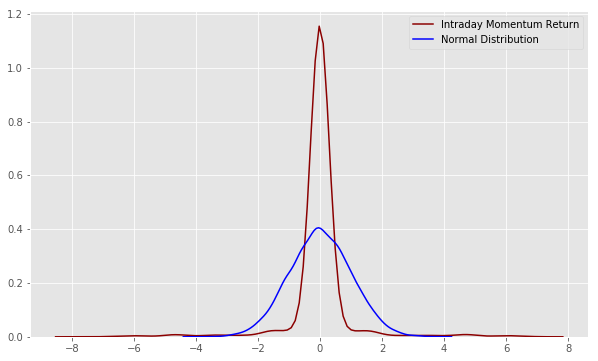

In [146]:
import seaborn as sns
returns = np.log(df['Index Return']).diff().dropna()
standard_return = (returns-returns.mean())/returns.std()

plt.figure(figsize=(10,6))
sns.kdeplot(standard_return, label="Intraday Momentum Return", bw=0.30, color='darkred')
sns.kdeplot(np.random.normal(size=len(df)), label="Normal Distribution", color = 'blue')

PART 2

Now that we have examined the strategy without a filter we will hand edit our long and short .csv files from above to only trade in the direction of the machine learning filter. We will import the edited files and and check the metrics in comparison to the strategy alone.

You can recreate this by first running the Capstone Machine Learning IPYNB, taking the machine learning prediction output into CapstoneML.csv and removing the counter prediction direction trades by changing the position column to 0 in the MomentumSHORT and MomentumLONG files before renaming and importing below as df3 and df4.

In [147]:
#we will now combine our long and short edited files

df3 = pd.read_csv('MomentumLONG1.csv', parse_dates = True, index_col=0)
df4 = pd.read_csv('MomentumSHORT1.csv', parse_dates = True, index_col=0)


In [148]:
#Before combining we need to calculate a couple of metircs regarding time in market

Regime3 = df3['Position'].rolling(2).apply(lambda x: x[0] != x[-1], raw=True).sum().astype(int)
Buy_Orders3 = Regime3/2
Average_Hold3 = ((df3['Position'].sum())/Buy_Orders3)*1
Number_of_periods3 = len(df3.index)
Time_in_Market3 = (Average_Hold3*Buy_Orders3)/Number_of_periods3


Regime2 = df4['Position'].rolling(2).apply(lambda x: x[0] != x[-1], raw=True).sum().astype(int)
Buy_Orders2 = Regime2/2
Average_Hold2 = ((df4['Position'].sum())/Buy_Orders)*-1
Number_of_periods2 = len(df4.index)
Time_in_Market4 = (Average_Hold2*Buy_Orders2)/Number_of_periods2


In [149]:
### Now combine

#Now combine and subtract trading costs to get results
combined_return = (df3['Strategy Return'] + df4['Strategy Return'])-((0.0001*7)/len(df))#trading costs/length of the index to roughly add in the costs
df3['Combined Return'] = combined_return
df3['Combined Cumulative'] = (1 + df3['Combined Return']).cumprod()

Total Return = 0.0166355644223887
PORTFOLIO CAGR= 0.0998133865343322
Max Portfolio DD =  -0.00867322824335004
TIME IN MARKET ADJUSTED CAGR= 0.309100349467761
Percent of time in market= 0.3229157996948259


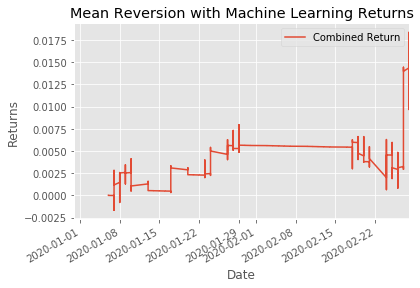

In [150]:
#Strategy Performance Metircs

Return = df3['Combined Return'].sum()
CAGR = Return*6
lookback = 10000
df3['rolling_maximum_combined'] = df3['Combined Cumulative'].rolling(lookback, min_periods=1).max()
df3['daily_drawdowns'] = df3['Combined Cumulative']/df3['rolling_maximum_combined'] - 1.0
df3['max_daily_drawdown'] = df3['daily_drawdowns'].rolling(lookback, min_periods=1).min()
Total_Time = (Time_in_Market3+Time_in_Market4)
ADJCAGR = CAGR/Total_Time


#### PRINT & PLOT   ###

print("Total Return =",Return)
print("PORTFOLIO CAGR=", CAGR)
print("Max Portfolio DD = ", df3['max_daily_drawdown'].min())
print("TIME IN MARKET ADJUSTED CAGR=", ADJCAGR)
print("Percent of time in market=", Total_Time)

df3['Combined Return'].cumsum().plot()
plt.title("Mean Reversion with Machine Learning Returns")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.legend()



In [151]:
#Calculate Volatility
volatility = df3['Combined Return'].std()
Annualised_Vol = volatility*((288*252)**0.5)
print("Volatility = ",Annualised_Vol)

#Sharpe Ratio
dailysharpe = df3['Combined Return'].mean()/df3['Combined Return'].std()# Sharpe Ratio
SharpeRatio = dailysharpe*((288*252)**0.5)#Annualized Sharpe (288 5minute periods per day daily sharpe by square root of number of trading days per year)
print("Sharpe Ratio = ", SharpeRatio)

skew2 = skew(df3['Combined Return'].dropna())
print("Skew",skew2)

kurtosis2 = kurtosis(df3['Combined Return'].dropna())
print("Kurtosis", kurtosis2)

Volatility =  0.035343665851487606
Sharpe Ratio =  3.001765171751571
Skew -0.45453745125956035
Kurtosis 34.2746817282249


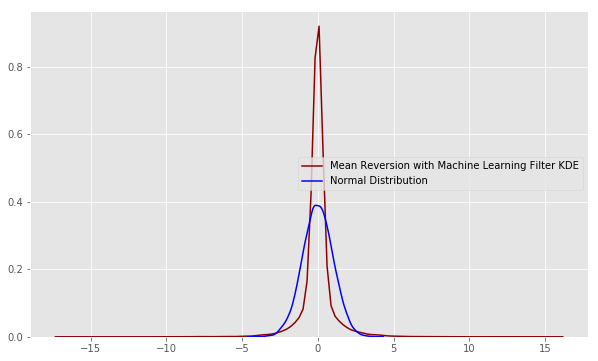

In [152]:
returns = np.log(df3['Combined Cumulative']).diff().dropna()
standard_return = (returns-returns.mean())/returns.std()

plt.figure(figsize=(10,6))
sns.kdeplot(standard_return, label="Mean Reversion with Machine Learning Filter KDE", bw=0.30, color='darkred')
sns.kdeplot(np.random.normal(size=len(df)), label="Normal Distribution", color = 'blue')

In [153]:
#VAR
df3.sort_values('Combined Return',inplace=True, ascending=True)
VAR_951=df3['Combined Return'].quantile(0.05)*(288**0.5)
VAR_991=df3['Combined Return'].quantile(0.01)*(288**0.5)
VAR_9991=df3['Combined Return'].quantile(0.001)*(288**0.5)

print("VAR at 95% confidence level = ", VAR_951)
print("VAR at 99% confidence level = ", VAR_991)
print("VAR at 99.9% confidence level = ", VAR_9991)

VAR at 95% confidence level =  -0.002894253287541968
VAR at 99% confidence level =  -0.007066241788415537
VAR at 99.9% confidence level =  -0.016843777668355046
